# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>

### Exercise 07.1
In the MD/MC code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

### Exercise 07.2

Use the MD/MC code to <span style="color:red">print out instantaneous values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo simulations</span> (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. <span style="color:red">Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.

Threshold: 0.0005
Estimated autocorrelation time: 36


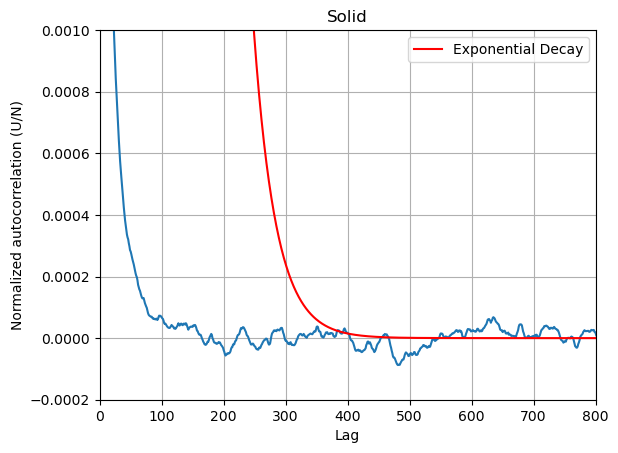

Threshold: 0.0005
Estimated autocorrelation time: 85


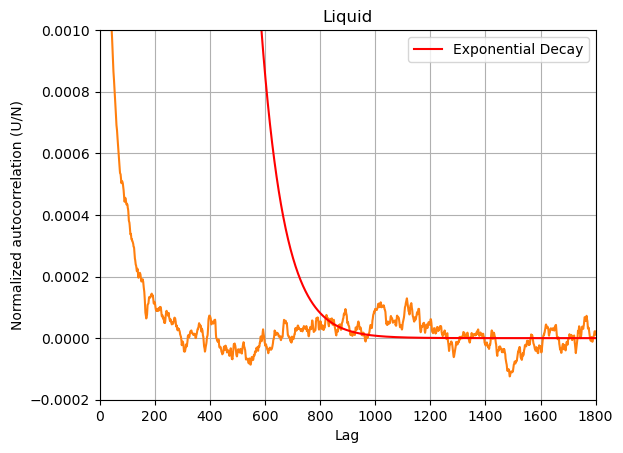

Threshold: 0.0005
Estimated autocorrelation time: 5


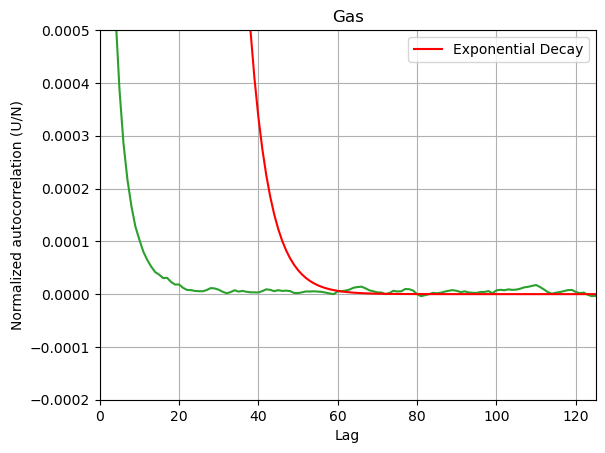

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

epot_solid = np.loadtxt('output_epot_solid.dat')
epot_data_solid = epot_solid[:, 1]      
epot_liquid = np.loadtxt('output_epot_liquid.dat')
epot_data_liquid = epot_liquid[:, 1]
epot_gas = np.loadtxt('output_epot_gas.dat')
epot_data_gas = epot_gas[:, 1]

def autocorr_fft(x):
    # Compute autocorrelation using FFT
    x = x - np.mean(x)
    f = np.fft.fft(x)
    acf = np.real(np.fft.ifft(f * np.conj(f)))
    #multiplies the Fourier coefficients by their complex conjugates,
    #takes the inverse Fourier transform of the result, and takes the real part of the output.
    #The resulting array acf contains the values of the autocorrelation function at each lag.
    acf /= len(x)   #Normalization
    #acf /= acf[0]
    return acf[:len(x)//2]

def autocorr_time(x, threshold):
    acf = autocorr_fft(x)
    #acf = acf / acf[0]
    for i in range(1, len(acf)):
        if acf[i] < threshold:
            return i
    return len(acf)-1

def plot_autocorr(data, name, colour, maxlag, minauto, maxauto):
    # Compute the autocorrelation function using FFT
    autocorr = autocorr_fft(data)

    # Plot the autocorrelation function
    plt.plot(autocorr, color=f'{colour}')
    plt.xlabel('Lag')
    plt.ylabel('Normalized autocorrelation (U/N)')
    plt.title(f'{name}')
    plt.grid(True)
    ax = plt.gca()
    ax.set_xlim([0, maxlag])
    ax.set_ylim([minauto, maxauto])
    
    # Compute exponential decay
    threshold=0.0005
    tau = autocorr_time(data, threshold)
    t = np.linspace(0, maxlag, maxlag + 1)
    exp_fun = np.exp(-t/tau)

    # Plot the exponential decay
    plt.plot(t, exp_fun, color='red', label='Exponential Decay')
    print(f"Threshold: {threshold}")
    print(f"Estimated autocorrelation time: {tau}")
    plt.legend()
    plt.show()
   
plot_autocorr(epot_data_solid, 'Solid', 'C0', 800, -0.0002, 0.001)
plot_autocorr(epot_data_liquid, 'Liquid', 'C1', 1800, -0.0002, 0.001)
plot_autocorr(epot_data_gas, 'Gas', 'C2', 125, -0.0002, 0.0005)

The Fourier transform is a mathematical technique for converting a time (or space) function into a frequency function. In particular, the Fourier transform allows us to decompose a periodic or aperiodic function into a sum of sinusoidal functions of different frequencies, each with its own amplitude and phase.

In the case of correlation, the Fourier transform is used to calculate the power spectral density of a function. The power spectral density represents the energy distribution of a function as a function of frequency, or how much of that energy is found in a particular frequency band.

The autocorrelation method that uses the Fourier transform, as in the previous code, exploits the fact that the autocorrelation function is the Fourier transform of the power spectral density. Therefore, it is possible to calculate the autocorrelation function from the power spectral density using the inverse Fourier transform.

In detail, the autocorrelation method that uses the Fourier transform is based on the following steps:

- Subtract the mean of the time series from the time series itself to obtain a series with zero mean.
- Compute the Fourier transform of the time series obtained in the previous step.
- Calculate the power spectral density as the square modulus of the Fourier transform obtained in the previous step.
- Calculate the inverse Fourier transform of the power spectral density obtained in the previous step, thus obtaining the autocorrelation function.

In this way, one can obtain the autocorrelation of the time series through the Fourier transform, without the need to calculate the autocorrelations directly. This method can be particularly useful in the case of very long time series, where the direct calculation of autocorrelations would be computationally expensive.

To compute the autocorrelation time, the autocorr_time function scans the autocorrelation acf starting from delay time i=1 and compares the current value of the autocorrelation with a threshold. As soon as the value of the autocorrelation becomes lower than the threshold, the function returns the autocorrelation time, i.e., the current index i. If the threshold is never exceeded, the function returns the last index, which is the length of the autocorrelation minus one (len(acf)-1).

Essentially, this function returns the first delay for which the normalized autocorrelation falls below the specified threshold, which can be interpreted as an estimate of the autocorrelation time of the time series. The threshold value specified by the threshold parameter can be used to adjust the sensitivity of the autocorrelation time estimate.

2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. <span style="color:red">Make pictures of these statistical uncertainties as a function of $L$.</span> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

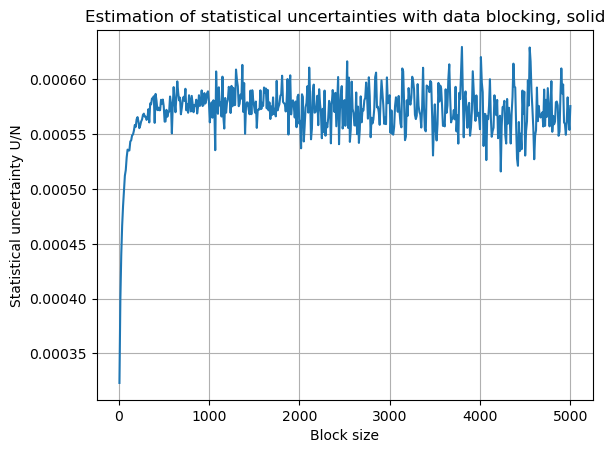

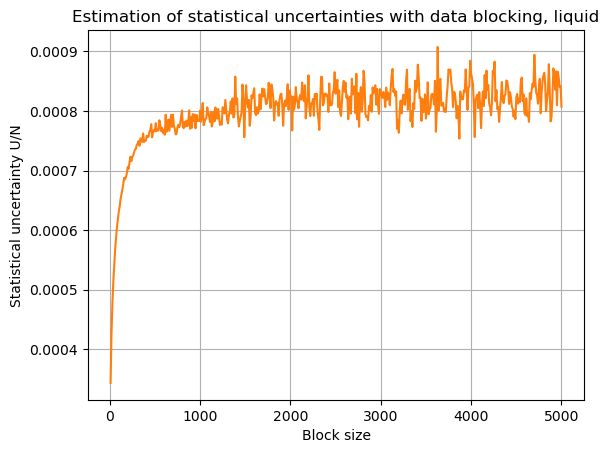

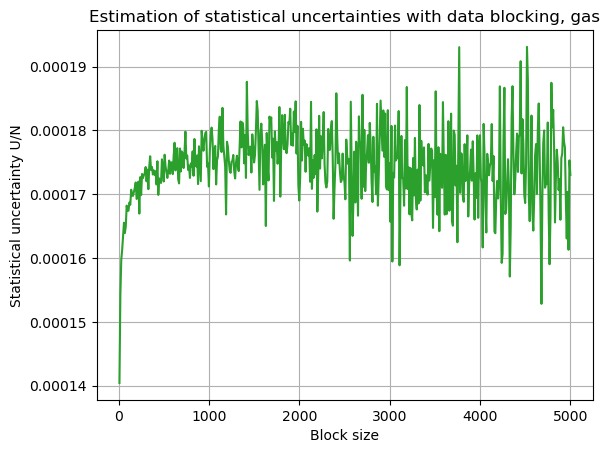

In [2]:
def data_blocking(data, phase, colour):
    nblocks = len(data)

    # Define the block sizes to use
    block_sizes = np.arange(10, 5001, 10)

    # Compute the expectation value of U/N and its statistical uncertainty for each block size
    means = []
    stds = []
    for block_size in block_sizes:
        nblocks = len(data) // block_size
        block_means = np.zeros(nblocks)
        for i in range(nblocks):
            block_means[i] = np.mean(data[i * block_size:(i + 1) * block_size])
            # compute the mean value for the current block by slicing the data array
            # to obtain the data points within the block range, and assign it to the corresponding index of block_means.
        means.append(np.mean(block_means))
        stds.append(np.sqrt(np.mean(block_means ** 2) - np.mean(block_means) ** 2) / np.sqrt(len(block_means) - 1))
        # compute the standard deviation of all block means

    # Plot the results
    plt.errorbar(block_sizes, stds, color=f'{colour}')
    plt.xlabel('Block size')
    plt.ylabel('Statistical uncertainty U/N')
    plt.title(f'Estimation of statistical uncertainties with data blocking, {phase}')
    plt.grid(True)
    plt.show()


data_blocking(epot_data_solid, 'solid', 'C0')
data_blocking(epot_data_liquid, 'liquid', 'C1')
data_blocking(epot_data_gas, 'gas', 'C2')

### Comments
Based on our analysis of uncertainty estimation with varying block sizes, we have observed that the statistical error reaches a stable level when using block sizes within the range of 1000 to 2000 steps per block.

These block sizes are also compatible with our study of autocorrelation. In fact, our analysis on autocorrelation suggests that 
even smaller block sizes can be used effectively.

We have also observed that excessively long block sizes lead to highly fluctuating statistical uncertainty. Hence, there seems to be an optimal range within which the block sizes should fall to achieve reliable and consistent results. In the simulation of the solid and liquid phase we have chosen to use 20 blocks of lenght 2000. However, in the case of the gas phase, we noticed that the measured values exhibited long fluctuations. As a result, we made the decision to use longer blocks with a length of 4000 to capture the dynamics of the gas phase more effectively.

### Exercise 07.3

<span style="color:red">Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the MD/MC code</span>: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

### Exercise 07.4

By means of your upgraded MD/MC code, equilibrate and <span style="color:red">perform MC NVT simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ... <span style="color:red"> and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.</span>

## Solid phase

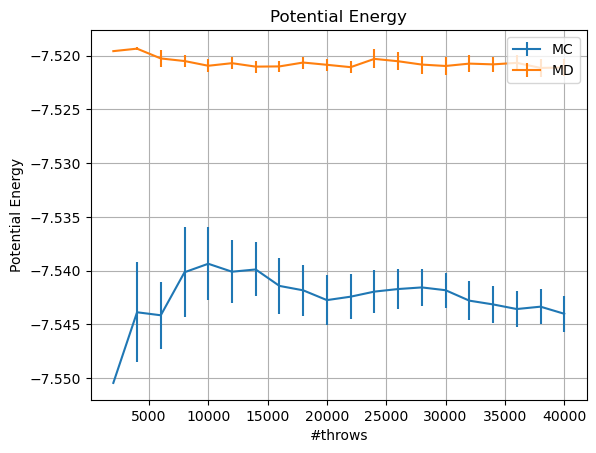

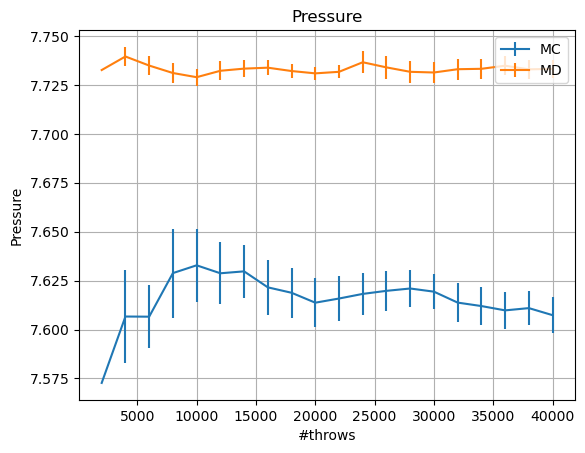

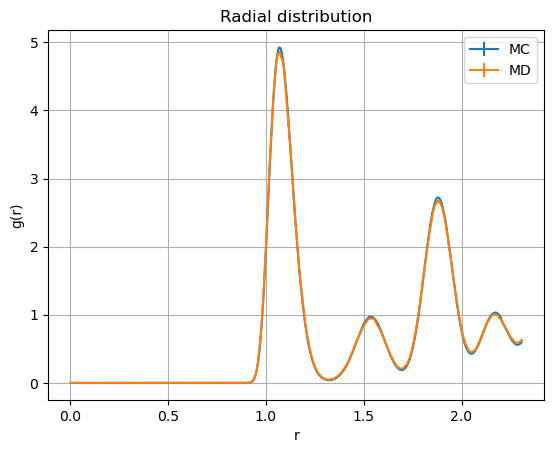

In [3]:
import pandas as pd

# Read the file into a pandas DataFrame
epot_data_MC = pd.read_csv('output_epot_solid_MC.dat', header=None, delim_whitespace=True, usecols=[2, 3])
pres_data_MC = pd.read_csv('output_pres_solid_MC.dat', header=None, delim_whitespace=True, usecols=[2, 3])
Gr_data_MC = pd.read_csv('output_Gr_solid_MC.dat', header=None, delim_whitespace=True, usecols=[1, 2])

epot_data_MD = pd.read_csv('output_epot_solid_MD.dat', header=None, delim_whitespace=True, usecols=[2, 3])
pres_data_MD = pd.read_csv('output_pres_solid_MD.dat', header=None, delim_whitespace=True, usecols=[2, 3])
Gr_data_MD = pd.read_csv('output_Gr_solid_MD.dat', header=None, delim_whitespace=True, usecols=[1, 2])

# Extract the values and errors as separate Series
epot_MC = epot_data_MC[2].tolist()
epot_err_MC = epot_data_MC[3].tolist()

pres_MC = pres_data_MC[2].tolist()
pres_err_MC = pres_data_MC[3].tolist()

Gr_MC = Gr_data_MC[1].tolist()
Gr_err_MC = Gr_data_MC[2].tolist()

epot_MD = epot_data_MD[2].tolist()
epot_err_MD = epot_data_MD[3].tolist()

pres_MD = pres_data_MD[2].tolist()
pres_err_MD = pres_data_MD[3].tolist()

Gr_MD = Gr_data_MD[1].tolist()
Gr_err_MD = Gr_data_MD[2].tolist()

M = 2000   # Number of throws in each block
N = 20     # Number of blocks


x = np.arange(1, len(epot_data_MC)+1) * M # Number of throws = block * (Number of throws in each block)

# Plot for Potential Energy
plt.errorbar(x, epot_MC, yerr=epot_err_MC, label = 'MC')
plt.errorbar(x, epot_MD, yerr=epot_err_MD, label = 'MD')
plt.xlabel('#throws')
plt.ylabel('Potential Energy')
plt.title('Potential Energy')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# Plot for Pressure
plt.errorbar(x, pres_MC, yerr=pres_err_MC, label = 'MC')
plt.errorbar(x, pres_MD, yerr=pres_err_MD, label = 'MD')
plt.xlabel('#throws')
plt.ylabel('Pressure')
plt.title('Pressure')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

box = 4.61329
y = np.arange(1, len(Gr_data_MC)+1)
bin_lenght = (box / 2)/len(Gr_data_MC)
plt.errorbar(y*bin_lenght, Gr_MC, yerr=Gr_err_MC, label = 'MC')
plt.errorbar(y*bin_lenght, Gr_MD, yerr=Gr_err_MD, label = 'MD')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Radial distribution')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Liquid phase

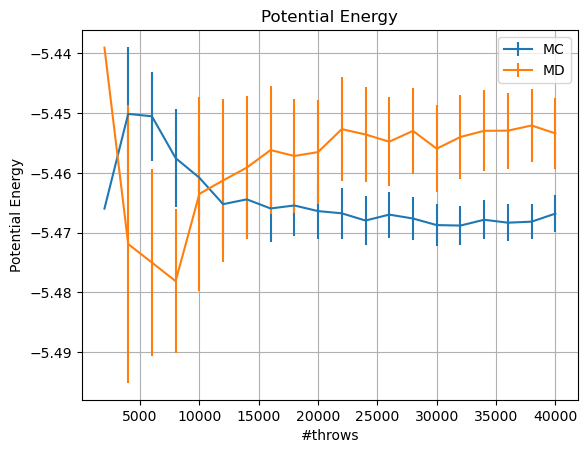

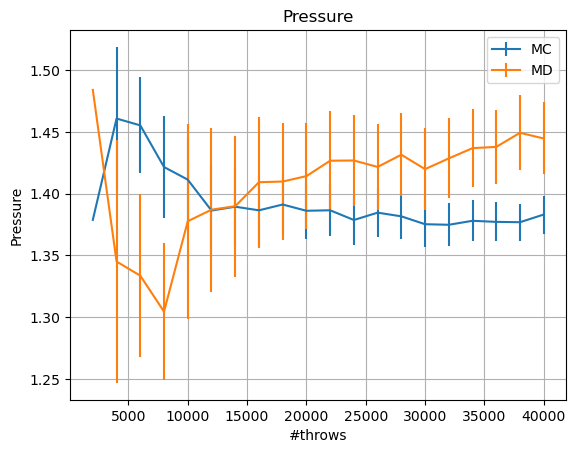

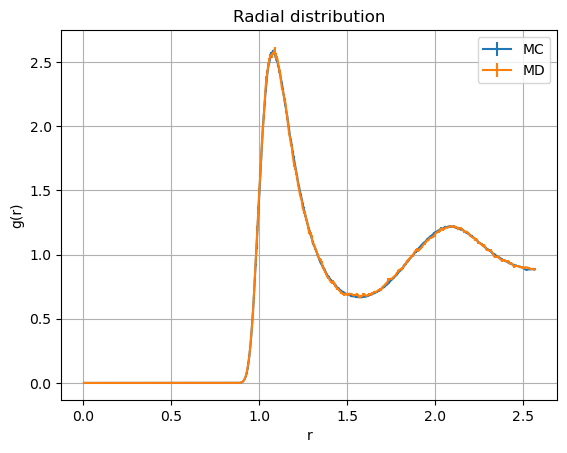

In [4]:
# Read the file into a pandas DataFrame
epot_data_MC = pd.read_csv('output_epot_liquid_MC.dat', header=None, delim_whitespace=True, usecols=[2, 3])
pres_data_MC = pd.read_csv('output_pres_liquid_MC.dat', header=None, delim_whitespace=True, usecols=[2, 3])
Gr_data_MC = pd.read_csv('output_Gr_liquid_MC.dat', header=None, delim_whitespace=True, usecols=[1, 2])

epot_data_MD = pd.read_csv('output_epot_liquid_MD.dat', header=None, delim_whitespace=True, usecols=[2, 3])
pres_data_MD = pd.read_csv('output_pres_liquid_MD.dat', header=None, delim_whitespace=True, usecols=[2, 3])
Gr_data_MD = pd.read_csv('output_Gr_liquid_MD.dat', header=None, delim_whitespace=True, usecols=[1, 2])

# Extract the values and errors as separate Series
epot_MC = epot_data_MC[2].tolist()
epot_err_MC = epot_data_MC[3].tolist()

pres_MC = pres_data_MC[2].tolist()
pres_err_MC = pres_data_MC[3].tolist()

Gr_MC = Gr_data_MC[1].tolist()
Gr_err_MC = Gr_data_MC[2].tolist()

epot_MD = epot_data_MD[2].tolist()
epot_err_MD = epot_data_MD[3].tolist()

pres_MD = pres_data_MD[2].tolist()
pres_err_MD = pres_data_MD[3].tolist()

Gr_MD = Gr_data_MD[1].tolist()
Gr_err_MD = Gr_data_MD[2].tolist()

M = 2000   # Number of throws in each block
N = 20     # Number of blocks

x = np.arange(1, len(epot_data_MC)+1) * M # Number of throws = block * (Number of throws in each block)

# Plot for Potential Energy
plt.errorbar(x, epot_MC, yerr=epot_err_MC, label = 'MC')
plt.errorbar(x, epot_MD, yerr=epot_err_MD, label = 'MD')
plt.xlabel('#throws')
plt.ylabel('Potential Energy')
plt.title('Potential Energy')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# Plot for Pressure
plt.errorbar(x, pres_MC, yerr=pres_err_MC, label = 'MC')
plt.errorbar(x, pres_MD, yerr=pres_err_MD, label = 'MD')
plt.xlabel('#throws')
plt.ylabel('Pressure')
plt.title('Pressure')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

box = 5.12993
y = np.arange(1, len(Gr_data_MC)+1)
bin_lenght = (box / 2)/len(Gr_data_MC)
plt.errorbar(y*bin_lenght, Gr_MC, yerr=Gr_err_MC, label = 'MC')
plt.errorbar(y*bin_lenght, Gr_MD, yerr=Gr_err_MD, label = 'MD')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Radial distribution')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Gas phase

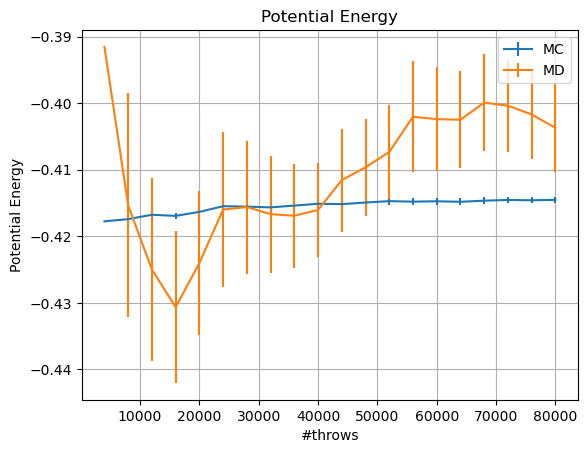

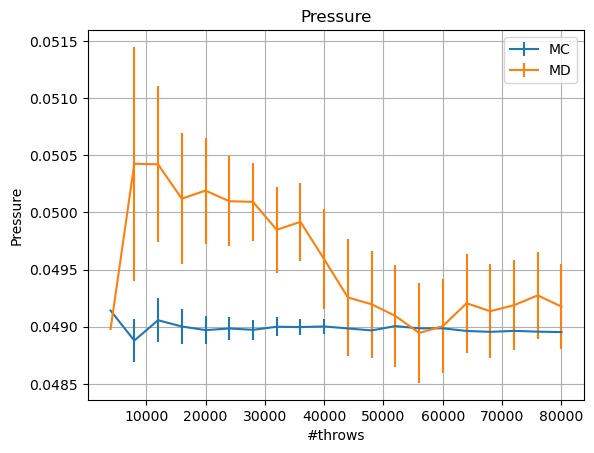

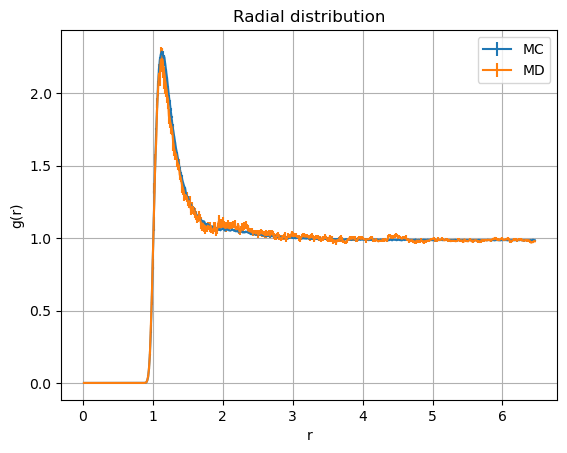

In [5]:
# Read the file into a pandas DataFrame
epot_data_MC = pd.read_csv('output_epot_gas_MC.dat', header=None, delim_whitespace=True, usecols=[2, 3])
pres_data_MC = pd.read_csv('output_pres_gas_MC.dat', header=None, delim_whitespace=True, usecols=[2, 3])
Gr_data_MC = pd.read_csv('output_Gr_gas_MC.dat', header=None, delim_whitespace=True, usecols=[1, 2])

epot_data_MD = pd.read_csv('output_epot_gas_MD.dat', header=None, delim_whitespace=True, usecols=[2, 3])
pres_data_MD = pd.read_csv('output_pres_gas_MD.dat', header=None, delim_whitespace=True, usecols=[2, 3])
Gr_data_MD = pd.read_csv('output_Gr_gas_MD.dat', header=None, delim_whitespace=True, usecols=[1, 2])

# Extract the values and errors as separate Series
epot_MC = epot_data_MC[2].tolist()
epot_err_MC = epot_data_MC[3].tolist()

pres_MC = pres_data_MC[2].tolist()
pres_err_MC = pres_data_MC[3].tolist()

Gr_MC = Gr_data_MC[1].tolist()
Gr_err_MC = Gr_data_MC[2].tolist()

epot_MD = epot_data_MD[2].tolist()
epot_err_MD = epot_data_MD[3].tolist()

pres_MD = pres_data_MD[2].tolist()
pres_err_MD = pres_data_MD[3].tolist()

Gr_MD = Gr_data_MD[1].tolist()
Gr_err_MD = Gr_data_MD[2].tolist()

M = 4000   # Number of throws in each block
N = 20     # Number of blocks

x = np.arange(1, len(epot_data_MC)+1) * M # Number of throws = block * (Number of throws in each block)

# Plot for Potential Energy
plt.errorbar(x, epot_MC, yerr=epot_err_MC, label = 'MC')
plt.errorbar(x, epot_MD, yerr=epot_err_MD, label = 'MD')
plt.xlabel('#throws')
plt.ylabel('Potential Energy')
plt.title('Potential Energy')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# Plot for Pressure
plt.errorbar(x, pres_MC, yerr=pres_err_MC, label = 'MC')
plt.errorbar(x, pres_MD, yerr=pres_err_MD, label = 'MD')
plt.xlabel('#throws')
plt.ylabel('Pressure')
plt.title('Pressure')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

box = 12.9266
y = np.arange(1, len(Gr_data_MC)+1)
bin_lenght = (box / 2)/len(Gr_data_MC)
plt.errorbar(y*bin_lenght, Gr_MC, yerr=Gr_err_MC, label = 'MC')
plt.errorbar(y*bin_lenght, Gr_MD, yerr=Gr_err_MD, label = 'MD')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Radial distribution')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### Comments
In this experience, we observe the strength of statistical physics, as it reveals the compatibility between the results obtained from Monte Carlo (MC) simulations and Molecular Dynamics (MD) simulations. It's important to note that perfection is not expected in our results since statistical physics provides ideal outcomes only in the limit of an infinite number of particles, whereas we are dealing with a system of only 108 particles. Additionally, the MC simulation reproduces a system with a fixed temperature, on the other hand, MD simulations preserve the system's energy.